In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from string import punctuation
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
from textblob import TextBlob
from collections import Counter
import re
import spacy

import matplotlib.pyplot as mp
%matplotlib inline

file = '/Users/nancy/Downloads/clickbait_data.txt'
with open(file, encoding="utf-8") as f_in:
    lines = [line.rstrip() for line in f_in]
    ybait = list([line for line in lines if line])

df_ycb = pd.DataFrame(ybait, columns=['text'])
df_ycb['clickbait'] = 1

file = '/Users/nancy/Downloads/non_clickbait_data.txt'
with open(file, encoding="utf-8") as f_in:
    lines = [line.rstrip() for line in f_in]
    nbait = list([line for line in lines if line])

df_ncb = pd.DataFrame(nbait, columns=['text'])
df_ncb['clickbait'] = 0

df = df_ycb.append(df_ncb, ignore_index=True).reset_index(drop=True)

In [25]:
question_words = ['who', 'whos', 'whose', 'what', 'whats', 'whatre', 'when', 'whenre', 'whens', 'couldnt',
        'where', 'wheres', 'whered', 'why', 'whys', 'can', 'cant', 'could', 'will', 'would', 'is',
        'isnt', 'should', 'shouldnt', 'you', 'your', 'youre', 'youll', 'youd', 'here', 'heres',
        'how', 'hows', 'howd', 'this', 'are', 'arent', 'which', 'does', 'doesnt']

modal_words = ['can', 'could', 'may', 'might', 'must', 'will', 'would', 'should', 'need', 'needs']

number_words = ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 
               'eleven', 'twelve', 'thirteen', 'fourteen', '']

contractions = ['tis', 'aint', 'amnt', 'arent', 'cant', 'couldve', 'couldnt', 'couldntve',
                'didnt', 'doesnt', 'dont', 'gonna', 'gotta', 'hadnt', 'hadntve', 'hasnt',
                'havent', 'hed', 'hednt', 'hedve', 'hell', 'hes', 'hesnt', 'howd', 'howll',
                'hows', 'id', 'idnt', 'idntve', 'idve', 'ill', 'im', 'ive', 'ivent', 'isnt',
                'itd', 'itdnt', 'itdntve', 'itdve', 'itll', 'its', 'itsnt', 'mightnt',
                'mightve', 'mustnt', 'mustntve', 'mustve', 'neednt', 'oclock', 'ol', 'oughtnt',
                'shant', 'shed', 'shednt', 'shedntve', 'shedve', 'shell', 'shes', 'shouldve',
                'shouldnt', 'shouldntve', 'somebodydve', 'somebodydntve', 'somebodys',
                'someoned', 'someonednt', 'someonedntve', 'someonedve', 'someonell', 'someones',
                'somethingd', 'somethingdnt', 'somethingdntve', 'somethingdve', 'somethingll',
                'somethings', 'thatll', 'thats', 'thatd', 'thered', 'therednt', 'theredntve',
                'theredve', 'therere', 'theres', 'theyd', 'theydnt', 'theydntve', 'theydve',
                'theydvent', 'theyll', 'theyontve', 'theyre', 'theyve', 'theyvent', 'wasnt',
                'wed', 'wedve', 'wednt', 'wedntve', 'well', 'wontve', 'were', 'weve', 'werent',
                'whatd', 'whatll', 'whatre', 'whats', 'whatve', 'whens', 'whered', 'wheres',
                'whereve', 'whod', 'whodve', 'wholl', 'whore', 'whos', 'whove', 'whyd', 'whyre',
                'whys', 'wont', 'wontve', 'wouldve', 'wouldnt', 'wouldntve', 'yall', 'yalldve',
                'yalldntve', 'yallll', 'yallont', 'yallllve', 'yallre', 'yallllvent', 'yaint',
                'youd', 'youdve', 'youll', 'youre', 'yourent', 'youve', 'youvent']

def process_text(text):
    result = text.replace('/', '').replace('\n', '')
    #result = re.sub(r'[1-9]+', 'number', result)
    result = re.sub(r'(\w)(\1{2,})', r'\1', result)
    result = re.sub(r'(?x)\b(?=\w*\d)\w+\s*', '', result)
    result = ''.join(t for t in result if t not in punctuation)
    result = re.sub(r' +', ' ', result).lower().strip()
    return result

stop = stopwords.words('english')
def cnt_stop_words(text):
    s = text.split()
    num = len([word for word in s if word in stop])
    return num

def num_contract(text):
    s = text.split()
    num = len([word for word in s if word in contractions])
    return num

def question_word(text):
    s = text.split()
    if bool(list(set(s) & set(question_words))):
        return 1
    else:
        return 0

def part_of_speech(text):
    s = text.split()
    nonstop = [word for word in s if word not in stop]
    pos = [part[1] for part in nltk.pos_tag(nonstop)]
    pos = ' '.join(pos)
    return pos

def modal_presence(text):
    s = text.split()
    if bool(list(set(s) & set(modal_words))):
        return 1
    else:
        return 0
    

def noun_counts(text):
    blobed = TextBlob(text)
    counts = Counter(tag for word,tag in blobed.tags)
    
    noun_tag_list = ['NN','NNS','NNP','NNPS']
    
    return counts['NN']+counts['NNS']+counts['NNP']+counts['NNPS']

def adj_counts(text):
    blobed = TextBlob(text)
    counts = Counter(tag for word,tag in blobed.tags)
    
    adj_tag_list = ['JJ','JJR','JJS']
        
    return counts['JJ']+counts['JJR']+counts['JJS']

def adv_counts(text):
    blobed = TextBlob(text)
    counts = Counter(tag for word,tag in blobed.tags)
    
    adv_tag_list = ['RB','RBR','RBS','WRB']
       
    return counts['RB']+counts['RBR']+counts['RBS']


def verb_counts(text):
    blobed = TextBlob(text)
    counts = Counter(tag for word,tag in blobed.tags)
    
    verb_tag_list = ['VB','VBD','VBG','VBN','VBP','VBZ']
    
    return counts['VB']+counts['VBD']+counts['VBG']+counts['VBN']+counts['VBP']+counts['VBZ']
    
    
def pron_counts(text):
    blobed = TextBlob(text)
    counts = Counter(tag for word,tag in blobed.tags)
    
    pron_tag_list = ['PRP','PRP$','WP','WP$']
    
    return counts['PRP']+counts['PRP$']+counts['WP']+counts['WP$']

def is_num(text):
    nlp = spacy.load('en_core_web_sm')
    doc = nlp(text)
    for token in doc:
        if token.tag_ == 'CD':
            return 1

In [27]:
%time

df['text']     = df['text'].apply(process_text)
df['question'] = df['text'].apply(question_word)
df['modal_words']   = df['text'].apply(modal_presence)
#df['num_adj'] = df['text'].apply(adj_counts)
df['num_adv'] = df['text'].apply(adv_counts)
#df['num_verb'] = df['text'].apply(verb_counts)
df['num_pron'] = df['text'].apply(pron_counts)
df['num_noun'] = df['text'].apply(noun_counts)
#df['contain_num'] = df['text'].apply(is_num)

df['num_words']       = df['text'].apply(lambda x: len(x.split()))
#df['part_speech']     = df['text'].apply(part_of_speech)
#df['num_contract']    = df['text'].apply(num_contract)
df['num_stop_words']  = df['text'].apply(cnt_stop_words)
df['stop_word_ratio'] = df['num_stop_words']/df['num_words']
#df['contract_ratio']  = df['num_contract']/df['num_words']

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 11.2 µs


In [4]:
#df.drop(['num_stop_words','num_contract', 'text'], axis=1, inplace=True)

In [24]:
x = pd.read_csv("2017_data.csv")

x.drop(['NumOfClaps', 'NumOfComments', 'articleTags', 'linkOfAuthorProfile', 'nameOfAuthor',
          'postingTime', 'readingTime', 'articleLink'], axis=1, inplace=True)

x.dropna(inplace=True)

x.drop_duplicates(subset=['names'], keep='first', inplace=True)

In [12]:
x['names']     = x['names'].apply(process_text)
x['question'] = x['names'].apply(question_word)
x['modal_words'] = x['names'].apply(modal_presence)
#x['num_adj'] = x['names'].apply(adj_counts)
x['num_adv'] = x['names'].apply(adv_counts)
#x['num_verb'] = x['names'].apply(verb_counts)
x['num_pron'] = x['names'].apply(pron_counts)
x['num_noun'] = x['names'].apply(noun_counts)
x['contain_num'] = x['names'].apply(is_num)

x['num_words']       = x['names'].apply(lambda y: len(y.split()))
#x['part_speech']     = x['names'].apply(part_of_speech)
#x['num_contract']    = x['names'].apply(num_contract)
x['num_stop_words']  = x['names'].apply(cnt_stop_words)
x['stop_word_ratio'] = x['num_stop_words']/x['num_words']
#x['contract_ratio']  = x['num_contract']/x['num_words']

NameError: name 'x' is not defined

In [26]:
x.dropna(inplace=True)

#new = x.drop(['num_stop_words','num_contract', 'names'], axis=1)

new = x.drop('names', axis=1)

new['clickbait'] = np.nan

In [27]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=0)

In [28]:
cvec = CountVectorizer()

X_train_pos = cvec.fit_transform(df_train['part_speech'])
X_test_pos  = cvec.transform(df_test['part_speech'])
X_val_pos = cvec.transform(new['part_speech'])

sc = StandardScaler(with_mean=False)
X_train_pos_sc = sc.fit_transform(X_train_pos)
X_test_pos_sc  = sc.transform(X_test_pos)
X_val_pos_sc = sc.transform(X_val_pos)

/Users/nancy/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/nancy/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/nancy/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/nancy/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [29]:
X_train_val = df_train.drop(['clickbait', 'part_speech'], axis=1).values
X_test_val  = df_test.drop(['clickbait', 'part_speech'], axis=1).values
X_val_val = new.drop(['clickbait', 'part_speech'], axis=1).values

sc = StandardScaler()
X_train_val_sc = sc.fit(X_train_val).transform(X_train_val)
X_test_val_sc  = sc.transform(X_test_val)
X_val_val_sc = sc.transform(X_val_val)

y_train = df_train['clickbait'].values
y_test  = df_test['clickbait'].values

In [30]:
from scipy import sparse


X_train = sparse.hstack([X_train_val_sc,  X_train_pos_sc]).tocsr()
X_test  = sparse.hstack([X_test_val_sc,  X_test_pos_sc]).tocsr()
X_val = sparse.hstack([X_val_val_sc,  X_val_pos_sc]).tocsr()

In [31]:
param_grid = [{'C': np.linspace(90,100,20)}]

grid_cv = GridSearchCV(LogisticRegression(), param_grid, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)

print(grid_cv.best_params_)
print(grid_cv.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   24.2s finished


{'C': 92.10526315789474}
0.85640625


In [32]:
model = LogisticRegression(penalty='l2', C=0.85640625)
model = model.fit(X_train, y_train)

predict1 = model.predict(X_test)
print(classification_report(y_test, predict1))

predict2 = model.predict(X_val)

print(predict2)

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      3204
           1       0.88      0.82      0.85      3196

   micro avg       0.86      0.86      0.86      6400
   macro avg       0.86      0.86      0.85      6400
weighted avg       0.86      0.86      0.85      6400

[0 1 1 ... 0 0 1]


In [14]:
new.columns

Index(['question', 'modal_words', 'num_adj', 'num_adv', 'num_verb', 'num_pron',
       'num_noun', 'num_words', 'part_speech', 'stop_word_ratio',
       'contract_ratio', 'clickbait'],
      dtype='object')

In [33]:
import numpy as np
coefs=model.coef_[0]
top_five = np.argpartition(coefs, -6)[-6:]
top_five_sorted=top_five[np.argsort(coefs[top_five])]
print(new.columns[top_five])

Index(['stop_word_ratio', 'num_pron', 'num_adv', 'num_noun', 'num_words',
       'question'],
      dtype='object')


In [34]:
x['results'] = predict2

In [35]:
pd.set_option('max.colwidth', 500)
pd.set_option('max.rows', 500)
x[x['results']==1][['names','results']]

,names,results
1,one size doesnt fit all the complexities of a global pim,1
2,why investing in data science,1
7,how to personalize your product or service with big data,1
10,what is needed to build a data science team from the ground up,1
16,confirmation bias may be your biggest problem too,1
20,victim of your success,1
28,six free books every data analyst should download,1
37,our experience of using age and sex disaggregated data,1
41,the new gold rush wall street wants your data,1
43,the data lake is a design pattern,1


Text(0, 0.5, 'Number of Headlines')

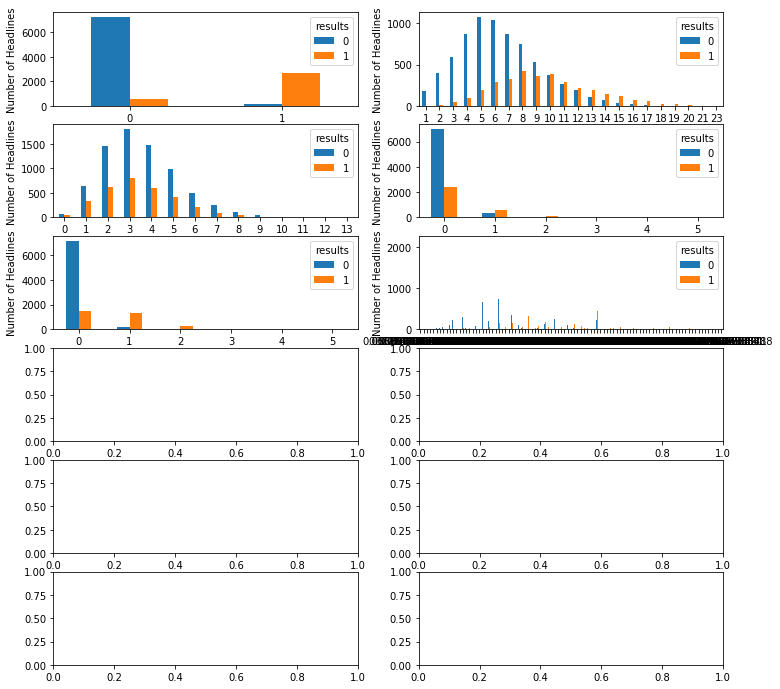

In [36]:
figure, axes = mp.subplots(nrows=6, ncols=2, figsize=(12,12))


plot = x.groupby('question')['results'].value_counts().unstack().plot.bar(ax=axes[0,0], rot=0)
plot.set_xlabel('Headline Question')
plot.set_ylabel('Number of Headlines')

plot = x.groupby('num_words')['results'].value_counts().unstack().plot.bar(ax=axes[0,1], rot=0)
plot.set_xlabel('Number of Words')
plot.set_ylabel('Number of Headlines')

plot = x.groupby('num_noun')['results'].value_counts().unstack().plot.bar(ax=axes[1,0], rot=0)
plot.set_xlabel('Number of nouns')
plot.set_ylabel('Number of Headlines')

plot = x.groupby('num_adv')['results'].value_counts().unstack().plot.bar(ax=axes[1,1], rot=0)
plot.set_xlabel('Number of adv')
plot.set_ylabel('Number of Headlines')

plot = x.groupby('num_pron')['results'].value_counts().unstack().plot.bar(ax=axes[2,0], rot=0)
plot.set_xlabel('Number of pronouns')
plot.set_ylabel('Number of Headlines')

plot = x.groupby('stop_word_ratio')['results'].value_counts().unstack().plot.bar(ax=axes[2,1], rot=0)
plot.set_xlabel('stop_word_ratio')
plot.set_ylabel('Number of Headlines')